## Analytical Grid: Composite functions

The $\tanh$ and skewnorm distribution functions to be used to create the grid.
$$h(x) = h_0\bigg(1 \pm \tanh{\frac{x - x_0}{s}}\bigg) + h_{min} $$
$$h(x) = A_0\frac{1}{2\sqrt{2\pi}}e^{-\frac{x^2}{2}} \bigg[1 + \textrm{erf}{\bigg(\frac{x}{\sqrt{2}}\bigg)} \bigg] $$

By tapering between various bathymetric subfunctions we can analytically construct the idealized domain. First define the forereef, reef crest, and lagoon bathymetry 
$$ h_f = 200(1 + \tanh{\frac{\pi(y - L_r)}{80}}) $$
$$ h_r = 1105\frac{1}{2\sqrt{2\pi}}e^{-\frac{y^2}{2}} \bigg[1 + \textrm{erf}{\bigg(\frac{y}{\sqrt{2}}\bigg)} \bigg] $$
$$ h_l = 10(1 - \tanh{\frac{\pi y}{50}}) $$
 
By composing these using a taper function of the same form as the $\tanh$ profile as above in the offshore direction, 
and a two-sided tanh taper function in the cross-shore direction (to transition from the reef flat to channel bathymetry smoothly)

$$ t_y = \frac{1}{2}\bigg(1 + \tanh{\frac{\pi(y - L_r)}{100}}\bigg) $$

$$ t_x = \frac{1}{2}\bigg[ \tanh{\frac{\pi(x + W_J)}{1250}} - \tanh{\frac{\pi(x - W_J)}{1250}} \bigg] $$

as follows
$$h_{lr} = h_lt_x + (h_l - h_r)(1 - t_x)$$
$$h(x,y) = h_lr(1 - t_y) + h_ft_y $$

In [7]:
import os
import subprocess
import numpy as np
from scipy.stats import skewnorm
import scipy.io as sio
import matlab.engine

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cmocean

# from pycoawst.tools.grid import s2z, cart2polar, rx0, rx1
# from pycoawst.utility.general import coriolis
from romspy.grid import s2z, cart2polar, rx0, rx1
from romspy.general import coriolis

mpl.rcParams['figure.dpi'] = 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'

In [8]:
class reef_grid():

    def __init__(self, Lm = 256, Mn = 128, coords = "polar", channels = 1, width_reef = np.pi/6, width_jet = 500, radius_island = 10e3, extent_offshore = 10e3,
                 extent_lagoon = 1e3, extent_reef = 2e3, extent_reefcrest = 100, depth_channel = 20, depth_reef = 2):
        
        self.Lm = Lm
        self.Mn = Mn
        self.coords = coords
        self.nc = channels
        self.Ri = radius_island
        
        self.Ll = extent_lagoon
        self.Lr = extent_reef
        self.Lrc = extent_reefcrest
        
        self.Ro = radius_island + extent_offshore
        self.Rl = radius_island + extent_lagoon
        self.Rr = radius_island + extent_reef
        
        self.hj = depth_channel
        self.hr = depth_reef
        
        self.Wj = width_jet
        self.Wr = width_reef
        
        if coords == "polar":
            self.projection = "stereographic"
            self.spherical = "T"
            self.r = np.linspace(self.Ri, self.Ro, Mn)
            self.t = np.linspace(0, self.nc*self.Wr, Lm) - self.nc*self.Wr/2
        elif coords == "xy":
            self.projection = "mercator"
            self.spherical = "F"
            self.x = np.linspace(-self.Wr/2, self.Wr/2, Lm)
            self.y = np.linspace(self.Ri, self.Ro, Mn)
        
    def coord_stretch(self, coord, scale = 3, x0 = 8.5e3):
        """normalized clustering of pts around x0"""
        #https://www3.nd.edu/~gtryggva/CFD-Course2017/Lecture-17-2017.pdf
        
        x = getattr(self, coord)
        Lx = x.max() - x.min()
        xn = (x - x.min())/Lx
        xn0 = (x0 - x.min())/Lx
        xc = xn + scale*(xn0 - xn)*(1 - xn)*xn
        x_stretched = xc*Lx + x.min()
        setattr(self, coord, x_stretched)
        return x_stretched
        
    def set_coords(self, phase = 0):
        if self.coords == "polar":
            self.t += phase
            self.T, self.R = np.meshgrid(np.flip(self.t), self.r, indexing = "xy")
            self.X, self.Y = self.R*np.cos(self.T), self.R*np.sin(self.T)
        elif self.coords == "xy":
            self.Y, self.X = np.meshgrid(self.y, self.x, indexing = "xy")
    
    def repeat(self, N):
        #self.X = np.tile(self.X, (1,N))
        xadd = self.X[:-1,:]
        yadd = self.Y[:-1,:]
        hadd = self.h[:-1,:]
        for i in range(N-1):
            self.X = np.concatenate((self.X, xadd + self.Wr*(i+1)))
            self.Y = np.concatenate((self.Y, yadd))
            self.h = np.concatenate((self.h, hadd))
        #if self.coords == "polar":
        
    def bathy_tanh(self, x, h0, scale, offset, hmin = 0, sgn = 1):
        return 0.5*(h0-hmin)*(1 + sgn*np.tanh( (x - offset)/scale)) + hmin
        #return h0*(1 + sgn*np.tanh( (x - offset)/scale)) + hmin
    
    def bathy_linear(self, x, h0, slope, offset, sgn = 1):
        return h0  + sgn*slope*(x - offset)
    
    def tanh2(self, x, s = 2.5e-2, w = 0.5):
        """"two sided tanh taper function. smaller s -> steeper roll off (correctly normalized now)"""
        return (1/2)*(1/np.tanh(np.pi*(w/s)))*( np.tanh(np.pi*(x + w)/s) - np.tanh(np.pi*(x - w)/s) )
    
    def export_matfile(self, grdname = "analytic"):
        """generate .mat file for COAWST mfiles to convert to .nc"""
        self.grdname = grdname
        self.mask =  G.h*0+1
        rho = {"x": self.X, "y": self.Y, "depth": self.h, "mask": mask} 
        sio.savemat(f"{grdname}.mat", {"rho": rho, "spherical": G.spherical, "projection": G.projection})
    
    def swan_halo(self, repeat = 2, sides = ["east", "west"], direction = "azimuthal"):
        """repeat domain on given sides (repeat) times"""
        
        #Repeat coords
        tlist = np.split(self.T, 2, axis = 1)
        self.T_swan = np.concatenate((tlist[0] + self.Wr/2, 
                                      self.T, 
                                      tlist[1] - self.Wr/2),
                                      axis = 1)
        
        rlist = np.split(self.R, 2, axis = 1)
        self.R_swan = np.concatenate((rlist[0] - self.Wr/2, 
                                      self.R, 
                                      rlist[1] + self.Wr/2),
                                      axis = 1)
        
        #Repeat bathymetry
        hlist = np.split(self.h, 2, axis = 1)
        self.h_swan = np.concatenate((hlist[1], 
                                      self.h, 
                                      np.flip(hlist[0],axis = 1)),
                                      axis = 1)
        self.mask_swan = self.h_swan*0 + 1
        
        self.X_swan, self.Y_swan = self.R_swan*np.cos(self.T_swan), self.R_swan*np.sin(self.T_swan)
        
    def matfile2roms(self):
        eng = matlab.engine.start_matlab()
        eng.cd(os.getcwd(),nargout=0)
        eng.mat2roms_mw(f"{self.grdname}.mat", f"roms_grid.nc", nargout=0)
        # eng.roms2swan( f"roms_grid.nc", nargout=0 )
        eng.roms2swan( matlab.double(self.X.tolist()), 
                       matlab.double(self.Y.tolist()), 
                       matlab.double(self.h.tolist()), 
                       matlab.double(self.mask.tolist()),nargout = 0 )
        eng.quit()

## Cartesian: Nic reef domain

In [629]:
G = reef_grid(coords = "xy", Lm = 98, Mn = 66, extent_offshore = 6e3, radius_island = 0, width_jet = 100, width_reef = 2e3)
G.coord_stretch("x", x0 = 0, scale = 2)
G.coord_stretch("y", x0 = 1.8e3, scale = 3.3)
G.set_coords()

G.hr = 1.5*8.5e2*skewnorm.pdf(G.Y, a = -2, loc = G.Rr, scale = 80) #crest slope bathymetry
#G.hf = G.bathy_tanh(G.Y, h0 = 200, scale = 1e3, offset = G.Rr + 1.75e3, hmin = G.hj, sgn = 1) #forereef bathymetry
G.hf = G.bathy_linear(G.Y, h0 = 20, slope = 0.1, offset = G.Rr) #forereef bathymetry
G.hf[G.hf<20] = 20
G.hl = G.bathy_tanh(G.Y, h0 = G.hj/2, scale = 50, offset = G.Rl, hmin = 2, sgn = -1) #lagoon bathymetry
G.taper_xi = G.tanh2(G.X - G.X*G.Y*2e-4, s = 1.5e2, w = G.Wj) #azimuthal taper
G.taper_eta = G.bathy_tanh(G.Y , h0 = 0.5, scale = G.Lrc, offset = G.Rr, hmin = 0) #radial taper function

G.hlc = G.hj*G.taper_xi + (G.hl - G.hr)*(1 - G.taper_xi)
G.h = G.hlc*(1 - G.taper_eta) + G.hf*G.taper_eta
G.h[G.h<.5] = .5

#G.repeat(4)

## Polar: Annulus grid

In [3]:
G = reef_grid(Lm = 168+2, Mn = 256+2, width_jet = 175)
G.coord_stretch("r", x0 = G.Rr-750, scale = 2.925)
G.coord_stretch("t", x0 = 0, scale = 3)
phase = np.pi/2
G.set_coords(phase = phase)

G.hr = 12e2*skewnorm.pdf(G.R, a = -2, loc = G.Rr, scale = 80) #reef flat bathymetry
#G.hf = G.bathy_tanh(G.R, h0 = 500, scale = 1.5e3, offset = G.Rr + 1e3, hmin = G.hj*.8, sgn = 1) #forereef bathymetry
G.hf = G.bathy_linear(G.R, h0 = 20, slope = 0.1, offset = G.Rr) #forereef bathymetry
G.hf[G.hf<20] = 20
G.hl = G.bathy_tanh(G.R, h0 = G.hj, scale = 50, offset = G.Rl, hmin = 2, sgn = -1) #lagoon bathymetry
G.taper_eta = G.bathy_tanh(G.R, h0 = 1.0, scale = 1.25*G.Lrc, offset = G.Rr, hmin = 0) #radial taper function
#G.taper_xi = G.tanh2(G.T - phase, s = 1e-2, w = G.Wj/(G.Rr*G.nc*G.Wr))

tapershape = np.exp((G.R - G.Rr)/4e1)
tapershape[tapershape > 1] = 1
G.taper_xi = G.tanh2(G.T - phase, s = 1.75e-2, w =  (1 + tapershape)* G.Wj/(G.Rr*G.nc*G.Wr)) #exponentially widen width at headlands

#G.taper_xi = G.tanh2(G.T - phase, s = 1e-2 + 1e-2*np.exp( 175*(G.R-G.Rr+0.25e3)/G.Ro), w = G.Wj/(G.Rr*G.nc*G.Wr)) #vary s
# G.taper_xi = G.tanh2(G.T - phase, s = (G.R - G.Ri)/G.Ro, w = G.Wj/(G.Rr*G.nc*G.Wr))
#G.taper_xi = G.tanh2(G.T - phase - 3e-4*(G.T - phase)*(G.R - 9e3), s = 1e-2, w = 0.5*G.Wj/(G.Rr*G.nc*G.Wr))
#G.taper_xi = G.tanh2( (G.T - phase)*-(G.R - 12e3)/.5e3, s = 1e-2, w = 0.5*G.Wj/(G.Rr*G.nc*G.Wr))
# tapertaper = np.exp( (G.R - 12e3)/1e3 )
# tapertaper[tapertaper >= 1] = 1
# G.taper_xi *= tapertaper

G.hlc = G.hj*G.taper_xi + (G.hl - G.hr)*(1 - G.taper_xi)
G.h = G.hlc*(1 - G.taper_eta) + G.hf*G.taper_eta
G.h[G.h<.5] = .5

#arc distance
G.S = (G.T - phase)*G.R

#add SWAN halo
G.swan_halo() 

In [4]:
%matplotlib widget
# G.swan_halo()
##plt.pcolormesh(G.T, G.R, G.h_swan, vmin = 0, vmax = 30)
#plt.pcolormesh(G.T_swan, G.R_swan, G.h_swan, vmin = 0, vmax = 30)
#plt.pcolormesh(G.T_swan) #np.diff(G.T_swan) )
#plt.pcolormesh(G.np.diff(G.T_swan, axis = 1)) 

# plt.pcolormesh(G.X_swan, G.Y_swan, G.h_swan)
# plt.pcolormesh(G.X,G.Y,G.h, cmap = "viridis")
# plt.gca().set_aspect("equal")
# plt.colorbar()
# plt.show()


In [5]:
# # plt.pcolormesh(G.X,G.Y,K, vmin = -1e-2, vmax = 1e-2,cmap = "RdBu_r")
# plt.figure()
# plt.pcolormesh(G.X,G.Y,G.taper_xi,cmap = "RdBu_r")
# plt.plot(12e3*np.cos(np.linspace(-np.pi/12,np.pi/12) + np.pi/2),
#          12e3*np.sin(np.linspace(-np.pi/12,np.pi/12) + np.pi/2),
#         color = "k")
# plt.colorbar()
# plt.show()

In [6]:
display(f"min d_r = { abs(np.diff(G.R, axis = 0)).min() }")
display(f"max d_r = { abs(np.diff(G.R, axis = 0)).max() }")
display(f"min d_s = { abs(np.diff(G.S, axis = 1)).min() }")
display(f"max d_s = { abs(np.diff(G.S, axis = 1)).max() }")

'min d_r = 5.1227148715715884'

'max d_r = 137.66845543806994'

'min d_s = 7.746357596802866'

'max d_s = 153.26745061651036'

## 3D Grid & Plotting

In [9]:
#Compute 3D grid and stiffness metrics

z = s2z(G.h, ns = 10, thetaS = 3.0, thetaB = 2.0, hc  = G.hj) #thermocline deep as channel
stiffness = rx1(z)
beckhaid = rx0(G.h)
display(f"min depth = {G.h.min()}")
display(f"max depth = {G.h.max()}")

Maximum rx1-value = 5.21026209184066
Maximum rx0-value = 0.31193301892454095


'min depth = 0.5'

'max depth = 820.0'

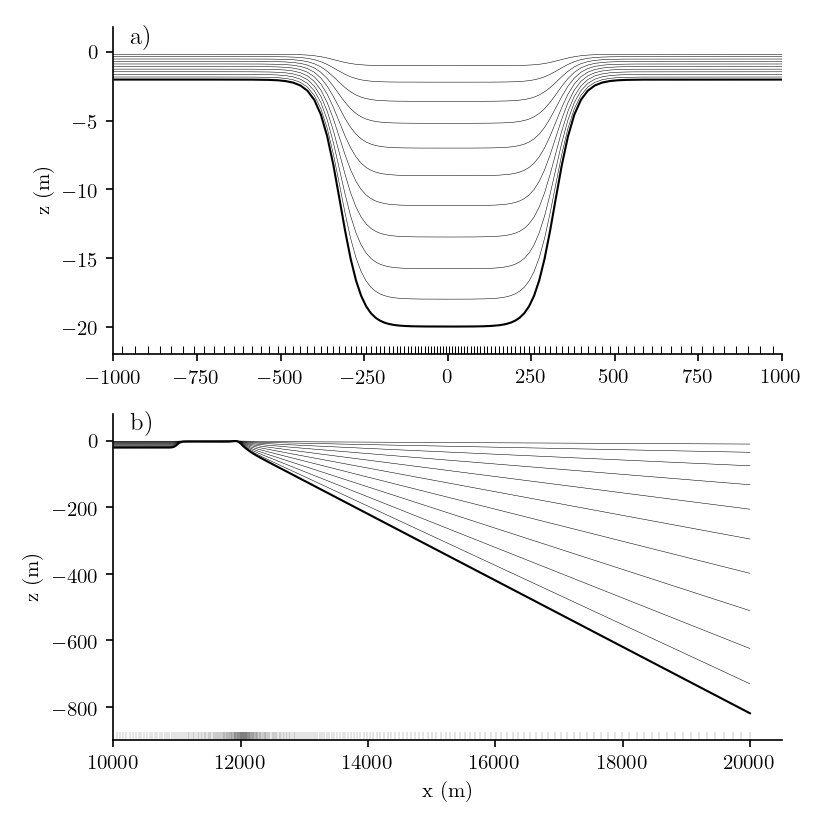

In [32]:
%matplotlib widget
import matplotlib.gridspec as gridspec
import seaborn as sns

i = 0 #86 for centerline
j = 45 
# sns.set_style("white")

radial, azimut = G.Y[j,:], G.X[:,i]
radial, azimut = G.R[:,i], G.S[j,:]

fig = plt.figure(figsize=(5.5,5.5), dpi = 150)
gs = gridspec.GridSpec(nrows=2, ncols=1)#, width_ratios = [2, 1.5])

ax = fig.add_subplot(gs[0,0])
plt.plot(azimut,  z[j,:], color = "k", linewidth = 0.25)
plt.gca().text(0.025, 0.95, "a)", fontsize = 12, transform=plt.gca().transAxes)

plt.plot(azimut, -G.h[j,:], color = "k", linewidth = 1)

sns.rugplot(x = azimut, color = "k", linewidth = 0.5)
#plt.gca().set_xlim(0, 6e3)
plt.gca().set_xlim(-1e3, 1e3)
#plt.gca().set_xlim(-3e3, 3e3)
plt.gca().set_ylabel("z (m)")

# ax.axes.axvline(-250, color = "k"); ax.axes.axvline( 250, color = "k")

ax = fig.add_subplot(gs[1,0])

plt.plot(radial, z[:,i], color = "k", linewidth = 0.25)
plt.plot(radial, -G.h[:,i], color = "k", linewidth = 1)
sns.rugplot(x = radial, color = "k", linewidth = 0.1)
#plt.gca().set_xlim(11e3,13e3); plt.gca().set_ylim(-5,0)
plt.gca().set_xlim(10e3, None)
# plt.gca().set_xlim(11.5e3, 12.5e3)
# plt.gca().set_ylim(-2,0)
#ax.axes.axvline(12000, color = "k")
plt.gca().set_ylabel("z (m)")
plt.gca().text(0.025, 0.95, "b)", fontsize = 12, transform=plt.gca().transAxes)

# fig.add_subplot(gs[:,1])
# plt.pcolormesh(G.X/1e3, G.Y/1e3, G.h, norm = LogNorm(vmin = 1, vmax = 1e3), cmap = cmocean.cm.ice_r, shading = "auto" )
# plt.gca().text(0.025, 0.95, "c)", fontsize = 12, transform=plt.gca().transAxes)

plt.gca().set_xlabel("x (m)")
# plt.gca().set_ylabel("y (km)")
# plt.gca().axis("equal")

plt.tight_layout()
sns.despine()

Figure ?: Cross-shore (a) and alongshore (b) cross-sections of the bathymetry. Notice the irregular spacing functions employed to better resolve reef crest and jet processes. The stretching function used is 

$$ x = L\zeta + a(x_0 - L\zeta)(1 - \zeta)\zeta $$

where $\zeta$ is the normalized coordinate (0-1), $L$ is the length of the domain the given direction, and $a$ is a tuning parameter determining the intensity of grid stretching/expansion about $x_0$.

/var/folders/mk/_l7g1hv926v_m4fp0vyh3x5r0000gn/T/ipykernel_40384/310579311.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X/1e3, Y/1e3, G.h, norm = LogNorm(vmin = 1, vmax = 1e2), cmap = cmocean.cm.ice_r, shading = "auto" )


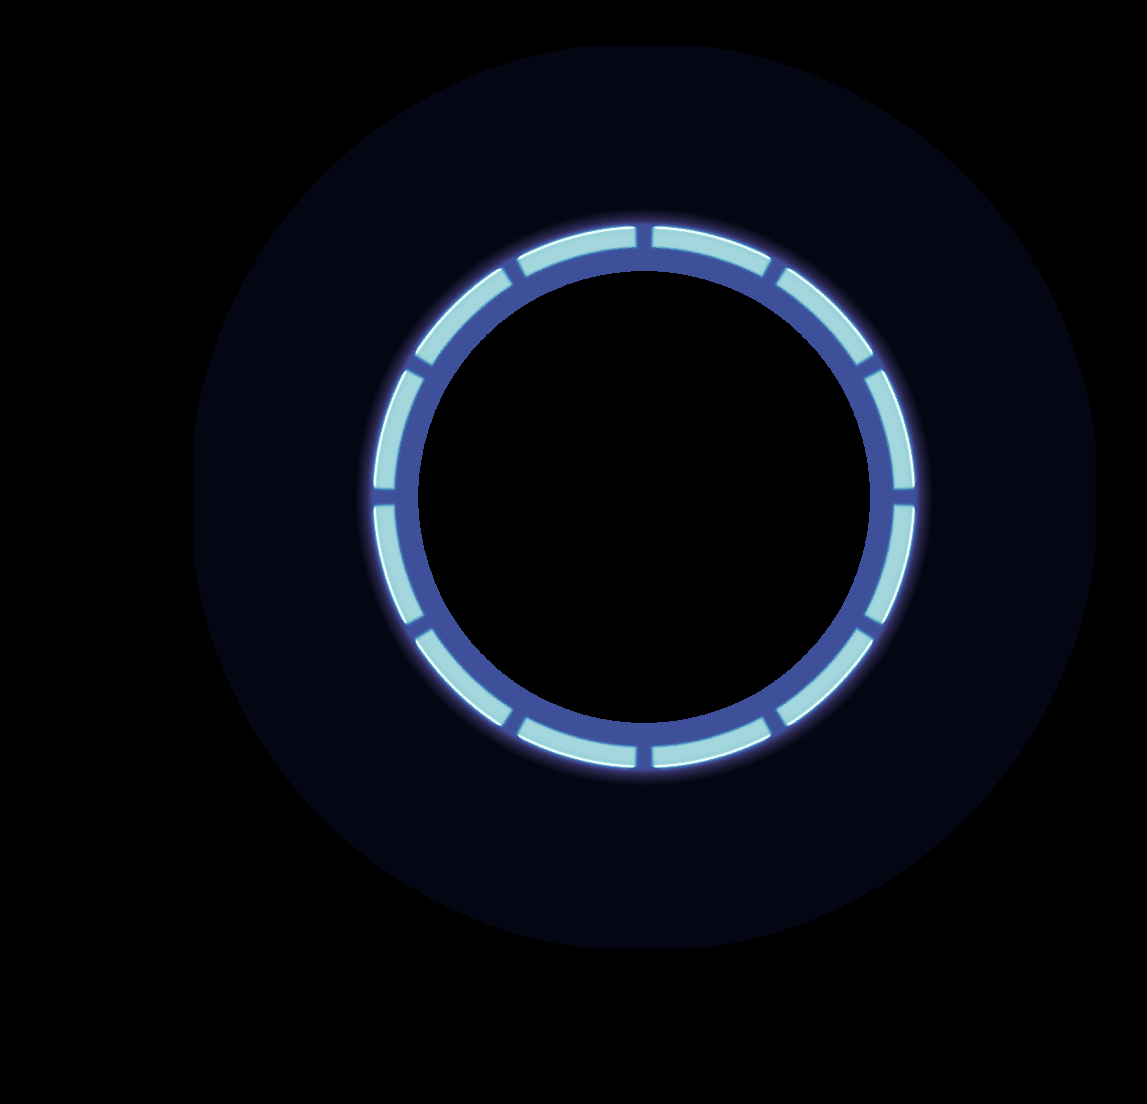

In [30]:
%matplotlib inline
#Pcolormesh 

fig, ax = plt.subplots(facecolor = "k", dpi = 300)
for k in range(12):
    
    T = G.T+k*np.pi/6
    X,Y = G.R*np.cos(T), G.R*np.sin(T)
    ax.pcolormesh(X/1e3, Y/1e3, G.h, norm = LogNorm(vmin = 1, vmax = 1e2), cmap = cmocean.cm.ice_r, shading = "auto" )

#ax.text(0.025, 0.95, "c)", fontsize = 12, transform=plt.gca().transAxes)
ax.set_facecolor("k")
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")

ax.set_xlim(-20,20)
ax.set_ylim(-20,20);
ax.set_aspect("equal")
fig.savefig("ann_bathy_dark.png")

## Export Grid Files

In [58]:
#Generate .mat file for COAWST mfiles to convert to .nc
grdname = ""

# lon, lat = cart2polar(X,Y)
# rho = {"lon": lon, "lat": lat, "depth": h, "mask": h*0+1}

G.spherical = "F"

mask =  G.h*0+1
rho = {"x": G.X.T, "y": G.Y.T, "depth": G.h.T, "mask": mask.T} 
sio.savemat(f"roms_grid.mat", {"rho": rho, "spherical": G.spherical, "projection": G.projection})

rho = {"x": G.X_swan.T, "y": G.Y_swan.T, "depth": G.h_swan.T, "mask": G.mask_swan.T} 
sio.savemat(f"swan_grid.mat", {"rho": rho, "spherical": G.spherical, "projection": G.projection})

In [59]:
eng = matlab.engine.start_matlab()
eng.cd(os.getcwd(),nargout=0)
eng.mat2roms_mw(f"roms_grid.mat", f"roms_grid.nc", nargout = 0)
eng.mat2roms_mw(f"swan_grid.mat", f"swan_grid.nc", nargout = 0)
eng.roms2swan( matlab.double(G.X_swan.T.tolist()), 
               matlab.double(G.Y_swan.T.tolist()), 
               matlab.double(G.h_swan.T.tolist()), 
               matlab.double(G.mask_swan.T.tolist()),nargout = 0 )
eng.quit()

 ## Defining Global Attributes...
 ## Defining Dimensions...
 ## Defining Variables and Attributes...
 ## Filling Variables...
 ## Defining Global Attributes...
 ## Defining Dimensions...
 ## Defining Variables and Attributes...
 ## Filling Variables...
I created swan_coord.grd and swan_bathy.bot:  these are part of INPUT.


In [55]:
#impose -fplane if necessary...
string = fr'''ncap2 -s "f=f*0+{coriolis(-30)};" -O {grdname}_grid.nc {grdname}_grid.nc'''
sp = subprocess.run(string, shell = True, check = True)

## Sandbox

In [382]:
def curvature_flow(S, x, y, xaxis = 1, yaxis = 0, kmin = 1):
    
    sx = np.gradient(S, axis = xaxis)/np.gradient(x, axis = xaxis)
    sy = np.gradient(S, axis = yaxis)/np.gradient(y, axis = yaxis)
    
    sxx = np.gradient(sx, axis = xaxis)/np.gradient(x, axis = xaxis)
    syy = np.gradient(sy, axis = yaxis)/np.gradient(y, axis = yaxis)
    
    sxy = np.gradient(sx, axis = yaxis)/np.gradient(y, axis = yaxis)
    
    K = ( (1+sx**2)*syy - 2*sx*sy*sxy + (1+sy**2)*sxx ) / (1+sx**2+sy**2)**(3/2)
    
    cff = (1+sx**2 + sy**2)
    st = 2*cff*K
    return K, st

In [116]:
K, St = curvature_flow(G.h, G.X, G.Y)

S = G.h.copy()

kmax = np.inf
while kmax > 0.001:

    K, St = curvature_flow(S, G.X, G.Y)
    S += St
    kmax = K.max()
#     print(K.max())

In [860]:
# import xarray as xr
# dg = xr.load_dataset("roms_grid.nc")

# dg["R"] = np.hypot(dg.x_rho, dg.y_rho)
# dg.R.shape

In [480]:
# plt.subplots(figsize=(2,2))
# plt.pcolormesh(G.X,G.Y,K, vmin = -1e-2, vmax = 1e-2,cmap = "RdBu_r")
# plt.colorbar()

$$ \frac{-\frac{dV}{dR} + \frac{V}{R} + f}{\lambda R} = \frac{-\frac{dV}{dR} + VK + f}{H_0} $$

In [60]:
import xarray as xr

In [74]:
ds = xr.load_dataset("../grid/swan_grid.nc")
ds

<xarray.Dataset>
Dimensions:    (one: 1, bath: 1, eta_rho: 258, xi_rho: 170, eta_psi: 257, xi_psi: 169, eta_u: 258, xi_u: 169, eta_v: 257, xi_v: 170)
Dimensions without coordinates: one, bath, eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/34)
    xl         (one) float64 1.035e+04
    el         (one) float64 1.034e+04
    JPRJ       |S2 b'ST'
    spherical  (one) |S1 b'F'
    depthmin   (one) int16 0
    depthmax   (one) int16 820
    ...         ...
    lon_v      (eta_v, xi_v) float64 -0.0468 -0.04546 ... 0.0906 0.09327
    mask_rho   (eta_rho, xi_rho) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    mask_u     (eta_u, xi_u) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    mask_v     (eta_v, xi_v) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    mask_psi   (eta_psi, xi_psi) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    angle      (eta_rho, xi_rho) float64 0.2458 0.2458 ... -0.2456 -0.2456
Attributes:
    type:     ROMS GRID file
    gridid:   theGridTitle
    history:  Created by create_roms_netcdf_grid_file, on 29-Oct-2021 12:20:41
    title:    ROMS Application

In [73]:
R = np.hypot(ds.x_rho, ds.y_rho)
R[-1,:]

<xarray.DataArray 'x_rho' (xi_rho: 340)>
array([19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
       19999.73820061, 19999.73820061, 19999.73820061, 19999.73820061,
...
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939,
       20000.26179939, 20000.26179939, 20000.26179939, 20000.26179939])
Dimensions without coordinates: xi_rho
Attributes:
    long_name:  x location of RHO-points
    units:      meter